# Programmation par contrainte: évaluation pratique
## 5-SDBD + mastère VALDOM, INSA Toulouse, janvier 2023

## Première partie

On utilise tout au long de ce sujet deux ensembles d’agents H = {h1, . . . hn} et F = {f1, . . . fn}. Chaque agent
hi ∈ H exprime ses préférences de couplage avec un agent de F à travers une liste L(hi) contenant les éléments de F
sans duplication. Pour tout k ∈ [1, n − 1], hi préfère être couplé avec le kème agent dans L(hi) que le k + 1ème agent.
De la même façon, chaque agent fj ∈ F exprime ses préférences de couplage avec un agent de H à travers une liste
L(fj ).

Un tuple (h, f ) est appelé un couple si h ∈ H et f ∈ F . Soit M un ensemble de couples. Un agent a préfère un
agent b à sa situation dans M si a n’appartient à aucun couple dans M ou si a préfère b à son partenaire dans M . Un
couple (h, f ) ∈ M bloque M si h préfère f à sa situation dans M et f préfère h à sa situation dans M .
Un mariage stable est un ensemble de couples M tel que chaque agent est couplé avec un seul agent et M n’admet
aucun couple bloquant. On note qu’une instance de ce problème peut admettre plusieurs solutions.

In [229]:
from config import setup
setup()

from docplex.cp.model import *
from docplex.cp.config import get_default

import numpy as np
%matplotlib inline

1. Proposez un modèle de programmation par contrainte pour trouver un mariage stable. Le modèle peut inclure
des contraintes logiques (par exemple if_then). L’utilisation de ce genre de contraintes est accessible dans la
documentation du solveur. Utilisez la recherche en profondeur par défaut ((’DepthFirst’) sans préciser des
heuristiques de branchements. N’affichez pas les traces d’exécutions internes du solveur.

In [442]:
from random import shuffle

def generate_prefs(n):    
    Lh = []
    Lf = []
    for i in range(n):
        h = list(set(list(range(n))))
        f = list(set(list(range(n))))
        shuffle(h)
        Lh.append(h)
        shuffle(f)
        Lf.append(f)
        
    return Lh, Lf

In [450]:
generate_prefs(5)

([[1, 2, 4, 0, 3],
  [4, 3, 0, 2, 1],
  [2, 3, 1, 4, 0],
  [2, 3, 0, 4, 1],
  [4, 0, 2, 1, 3]],
 [[3, 4, 0, 1, 2],
  [1, 2, 0, 3, 4],
  [1, 2, 4, 3, 0],
  [3, 0, 2, 4, 1],
  [0, 1, 2, 4, 3]])

In [473]:
#Données du sujet
#Nombre d'agents dans chaque groupe
n0 = 4

#Matrice de préférences de H (liste de listes)
#La préférence est décroissante : plus un agent a un indice bas, plus la préférence est élevée
Lh0 = [[2,3,1,4], 
       [4,1,3,2],
       [2,4,1,3],
       [3,1,4,2]]

#Matrice de préférences de F
Lf0 = [[2,1,3,4],
       [3,4,1,2],
       [1,3,4,2],
       [2,1,3,4]]

ones = np.ones(n,int)
Lh0 = (Lh0 - ones).tolist()
Lf0 = (Lf0 - ones).tolist()

In [492]:
def print_prefs(Lh,Lf,n):
    print("Lh =", Lh[0])
    for i in range(1,n):
        print("    ",Lh[i])
    print("")
    
    print("Lf =", Lf[0])
    for i in range(1,n):
        print("    ",Lf[i])
    print("")

In [493]:
print_prefs(Lh0,Lf0,n0)

Lh = [1, 2, 0, 3]
     [3, 0, 2, 1]
     [1, 3, 0, 2]
     [2, 0, 3, 1]

Lf = [1, 0, 2, 3]
     [2, 3, 0, 1]
     [0, 2, 3, 1]
     [1, 0, 2, 3]



In [594]:
def print_sol(sol):
    if sol.solve_status != "Infeasible":
        s = sol.get_all_var_solutions()
        indices = []
        for e in s:    
            if(e.get_name()[0] == 'c'):
                if e.get_value() == 1:
                    var = e.get_name()
                    indice = []
                    for l in var:
                        try:
                            i = int(l)
                            indice.append(i)
                        except:
                            pass
                    indices.append(indice)
                    
        res = "L'ensemble M={"
        for i in range(len(indices)):
            res = res + "(h_" + str(indices[i][0]) + ",f_" + str(indices[i][1]) + "),"
        res = res[:-1] + "}" + " est un mariage stable."

        print(res)
    else:
        print("Ce modèle ne possède pas de solutions.")

In [632]:
def generate_mdl1(n, Lh, Lf):
    mdl = CpoModel(name='Couples stables')

    #Lh, Lf = generate_prefs(n)
    #Variables
    couples = [mdl.binary_var_list(n, f"c{i}") for i in range(n)]
    h_index = mdl.integer_var_list(n, 0, n-1, name='ih') 
    f_index = mdl.integer_var_list(n, 0, n-1, name='if')


    for i in range(n):
        #indice de fi dans Lh
        mdl.add(f_index[i] == mdl.sum([couples[i][j] * (Lh[i].index(j)) for j in range(n)]))
        #indice de hi dans Lf
        mdl.add(h_index[i] == mdl.sum([couples[j][i] * (Lf[i].index(j)) for j in range(n)]))

    #Chaque agent ne peut être que dans un seul couple
    for i in range(n):
        mdl.add(mdl.sum([couples[i][j] for j in range(n)]) == 1)
        mdl.add(mdl.sum([couples[j][i] for j in range(n)]) == 1)

    # Blocking couple
    for i in range(n):
        for j in range(n):
            mdl.add(mdl.if_then(Lh[i].index(j) < f_index[i], Lf[j].index(i)>=h_index[i]))
            
    #print("Modèle généré : n =", n)
    #print_prefs(Lh,Lf,n)
    return mdl, couples


In [636]:
def generate_instance(n):
    Lh, Lf = generate_prefs(n)
    mdl, c = generate_mdl1(n, Lh, Lf)
    return mdl, c

In [637]:
mdl,c = generate_instance(4)
mdl.solve(trace_log=False)
print_sol(sol)

L'ensemble M={(h_0,f_0),(h_1,f_1),(h_2,f_3),(h_3,f_2)} est un mariage stable.


3. Proposez deux stratégies de recherches différentes qui vous semblent très différentes (i.e., deux combinaisons de type <heuristique de choix de variables + heuristique de choix de valeurs>). On note ces deux stratégies par S1 et S2


4. On veut tester S1 et S2 avec une recherche en profondeur sans et avec redémarrage (’DepthFirst’ vs ’Restart’). Voici le protocole de l’étude expérimentale :

Générez différentes instances randomisées du problème avec différentes tailles (à partir de n = 5). Pour chaque taille, générez 5 instances.


In [638]:
def generate_5_instances(n):
    instances = []
    for i in range(5):
        mdl, c = generate_instance(n)
        instances.append((mdl,c))
    return instances

Lancez les 4 expérimentations (S1 et S2 avec une recherche en profondeur sans et avec redémarrage) avec vos jeux de données. Fixez le temps limite à 200s pour chaque exécution.

Reportez le temps d’exécution et le nombre de nœuds dans des figures en fonction de la taille.


In [688]:
import matplotlib.pyplot as plt

def print_plots(tailles):

    temps_s1_sans_restart = []
    temps_s1_avec_restart = []
    temps_s2_sans_restart = []
    temps_s2_avec_restart = []

    nb_noeuds_s1_sans_restart = []
    nb_noeuds_s1_avec_restart = []
    nb_noeuds_s2_sans_restart = []
    nb_noeuds_s2_avec_restart = []

    for taille in tailles:
        #Variables pour le calcul des moyennes du temps d'exécution
        temps_moyen_s1_sans_rst = 0
        temps_moyen_s1_avec_rst = 0
        temps_moyen_s2_sans_rst = 0
        temps_moyen_s2_avec_rst = 0
        nb_noeuds_moyen_s1_sans_rst = 0
        nb_noeuds_moyen_s1_avec_rst = 0
        nb_noeuds_moyen_s2_sans_rst = 0
        nb_noeuds_moyen_s2_avec_rst = 0
        
        #Création des 5 instances (on aura 5 instances pour chaque taille)
        instances = generate_5_instances(taille)
        
        
        for instance in instances:
            #Création du modèle
            mdl, couples = instance
            
            #S1 : default
            
            sol1 = mdl.solve(trace_log=False, SearchType="DepthFirst", TimeLimit=200)
            temps_moyen_s1_sans_rst += sol1.get_solver_info('TotalTime')
            nb_noeuds_moyen_s1_sans_rst += sol1.get_solver_info('NumberOfChoicePoints')
            
            sol2 = mdl.solve(trace_log=False, SearchType="Restart", TimeLimit=200)
            temps_moyen_s1_avec_rst += sol2.get_solver_info('TotalTime')
            nb_noeuds_moyen_s1_avec_rst += sol2.get_solver_info('NumberOfChoicePoints')
            
            #S2 : <random, random>
            
            mdl2 = mdl
            S2 = mdl.search_phase(varchooser=mdl.select_random_var(),valuechooser=mdl.select_random_value())
            mdl.add_search_phase(S2)
            
            sol3 = mdl.solve(trace_log=False, SearchType="DepthFirst", TimeLimit=200)
            temps_moyen_s2_sans_rst += sol3.get_solver_info('TotalTime')
            nb_noeuds_moyen_s2_sans_rst += sol3.get_solver_info('NumberOfChoicePoints')
            
            sol4 = mdl.solve(trace_log=False, SearchType="Restart", TimeLimit=200)
            temps_moyen_s2_avec_rst += sol4.get_solver_info('TotalTime')
            nb_noeuds_moyen_s2_avec_rst += sol4.get_solver_info('NumberOfChoicePoints')

        temps_s1_sans_restart.append(temps_moyen_s1_sans_rst/5)
        nb_noeuds_s1_sans_restart.append(nb_noeuds_moyen_s1_sans_rst/5)

        temps_s2_avec_restart.append(temps_moyen_s2_avec_rst/5)
        nb_noeuds_s2_avec_restart.append(nb_noeuds_moyen_s2_avec_rst/5)


    plt.plot(tailles, temps_s1_sans_restart, label="S1 sans restart")
    plt.plot(tailles, temps_s1_avec_restart, label="S1 avec restart")
    plt.plot(tailles, temps_s2_sans_restart, label="S2 sans restart")
    plt.plot(tailles, temps_s2_avec_restart, label="S2 avec restart")
    plt.ylabel("Temps d'exécution")
    plt.xlabel("Taille des instances")
    plt.legend()
    plt.show()

    plt.plot(tailles, nb_noeuds_s1_sans_restart, label="S1 sans restart")
    plt.plot(tailles, nb_noeuds_s1_avec_restart, label="S1 avec restart")
    plt.plot(tailles, nb_noeuds_s2_sans_restart, label="S2 sans restart")
    plt.plot(tailles, nb_noeuds_s2_avec_restart, label="S2 avec restart")
    plt.ylabel("Nombre de noeuds")
    plt.xlabel("Taille des instances")
    plt.legend()
    plt.show()

In [678]:
sizes = [x for x in range(5,12)]

ValueError: x and y must have same first dimension, but have shapes (7,) and (0,)

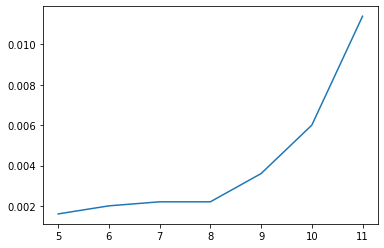

In [689]:
print_plots(sizes)

## Seconde partie

In [597]:
mdl = CpoModel(name='couples stables avec score')
n=4

#Variables
couples = [mdl.binary_var_list(n, f"c{i}") for i in range(n)]
h_index = mdl.integer_var_list(n, 0, n-1, name='ih') 
f_index = mdl.integer_var_list(n, 0, n-1, name='if')

score = mdl.integer_var(0,n-1,"z")

DH = mdl.max(h_index)
DF = mdl.max(f_index)

#Contrainte sur le score
mdl.add(score == abs(DH - DF))

#Récupération des indexes de h et f dans couples
for i in range(n):
    #indice de fi dans Lh
    mdl.add(f_index[i] == mdl.sum([couples[i][j] * (Lh[i].index(j)) for j in range(n)]))
    #indice de hi dans Lf
    mdl.add(h_index[i] == mdl.sum([couples[j][i] * (Lf[i].index(j)) for j in range(n)]))
        
#Chaque agent ne peut être que dans un seul couple
for i in range(n):
    mdl.add(mdl.sum([couples[i][j] for j in range(n)]) == 1)
    mdl.add(mdl.sum([couples[j][i] for j in range(n)]) == 1)

#Couple bloquants
for i in range(n):
    for j in range(n):
        mdl.add(mdl.if_then(Lh[i].index(j) < f_index[i], Lf[j].index(i)>=h_index[i]))

#Minimisation du score       
mdl.add(mdl.minimize(score))

In [609]:
def print_indexes(sol):
    if sol.solve_status != "Infeasible":
        s = sol.get_all_var_solutions()
        If = []
        Ih = []
        for e in s:    
            if(e.get_name()[0] == 'i'):
                if(e.get_name()[1] == 'f'):
                    If.append(e.get_value())
                if(e.get_name()[1] == 'h'):
                    Ih.append(e.get_value())
    
        print("Ih =", Ih,"\nIf =", If)

In [650]:
sol = mdl.solve(trace_log=False)
print_sol(sol)
print_indexes(sol)

L'ensemble M={(h_0,f_0),(h_1,f_2),(h_2,f_1),(h_3,f_3)} est un mariage stable.
Ih = [0, 3, 1, 3] 
If = [1, 0, 3, 1]
